In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

In [12]:
def mixup_data(x, y, alpha=1.0):
    """Apply MixUp augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def cutmix_data(x, y, alpha=1.0):
    """Apply CutMix augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    # Generate random bounding box
    H, W = x.shape[2], x.shape[3]
    r_x, r_y = np.random.randint(W), np.random.randint(H)
    r_w, r_h = int(W * np.sqrt(1 - lam)), int(H * np.sqrt(1 - lam))

    x[:, :, r_x:r_x+r_w, r_y:r_y+r_h] = x[index, :, r_x:r_x+r_w, r_y:r_y+r_h]

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [13]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [14]:

# Load CIFAR-10 dataset
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)




In [15]:

dataset1 = torchvision.datasets.CIFAR10(root='./data/', train=False,
                                        download=True, transform=transforms.ToTensor())

dataset2 = torchvision.datasets.CIFAR10(root='./data/', train=True,
                                        download=True, transform=transforms.ToTensor())


images = np.append(dataset1.data, dataset2.data, axis=0)
all_targets = dataset1.targets + dataset2.targets

images_transposed = np.transpose(images, (0,3,1,2))
#---------------------------------#


all_images = images_transposed

quantiles = np.load('quantiles001.npy')


mask_val = 0.60

mask = quantiles <= mask_val
all_indexes = np.arange(0, len(all_targets))
selected_indexes = (all_indexes[mask])

test_set_size = int(selected_indexes.shape[0]/10)

print(test_set_size)

3600


(3600, 3, 32, 32)
0
[[[0.3529412  0.3529412  0.35686275 ... 0.40392157 0.39215687 0.39215687]
  [0.36078432 0.3647059  0.36862746 ... 0.44705883 0.40392157 0.4       ]
  [0.3647059  0.3647059  0.36862746 ... 0.44705883 0.40392157 0.39607844]
  ...
  [0.39607844 0.39607844 0.4        ... 0.36862746 0.36078432 0.35686275]
  [0.39215687 0.39607844 0.4        ... 0.3647059  0.3529412  0.3529412 ]
  [0.3882353  0.39215687 0.39607844 ... 0.36078432 0.3529412  0.34901962]]

 [[0.4862745  0.4862745  0.49019608 ... 0.5137255  0.5019608  0.5058824 ]
  [0.49803922 0.49803922 0.5019608  ... 0.5372549  0.50980395 0.5176471 ]
  [0.5019608  0.49803922 0.5019608  ... 0.52156866 0.5058824  0.5176471 ]
  ...
  [0.52156866 0.5176471  0.52156866 ... 0.4862745  0.47843137 0.47843137]
  [0.5137255  0.5176471  0.52156866 ... 0.48235294 0.47058824 0.4745098 ]
  [0.50980395 0.50980395 0.5176471  ... 0.47843137 0.47058824 0.47058824]]

 [[0.58431375 0.58431375 0.5882353  ... 0.5803922  0.57254905 0.57254905]
  

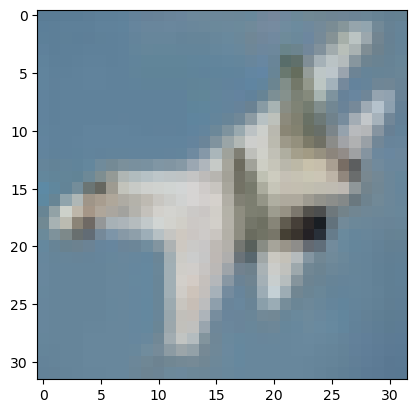

In [16]:
partitioned_images = np.load('partitioned_images.npy')
partitioned_targets = np.load('partitioned_targets.npy')

choice = np.random.choice(range(partitioned_images.shape[0]), size=(test_set_size,), replace=False)    
ind = np.zeros(partitioned_images.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind

#import sklearn
#from sklearn.model_selection import train_test_split
#train_images, test_images, train_targets, test_targets = train_test_split(
    #partitioned_images, partitioned_targets, test_size=0.1)


#train_images = partitioned_images[0:-2400][:][:][:]
#train_targets = partitioned_targets[0:-2400]

#test_images = partitioned_images[-2400:][:][:][:]
#test_targets = partitioned_targets[-2400:]

train_images = partitioned_images[rest][:][:][:]
train_targets = partitioned_targets[rest]

test_images = partitioned_images[ind][:][:][:]
test_targets = partitioned_targets[ind]

print(test_images.shape)

from torch.utils.data import Dataset
class CustomCIFAR(Dataset):
    #def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    def __init__(self, images, targets, transform=None):
        self.img_labels = torch.from_numpy(targets)
        self.imgs = torch.from_numpy(images).float()
        self.transform = transform
        self.tensor_transform = torchvision.transforms.ToTensor()

        #self.img_labels = self.tensor_transform(self.img_labels)
        #self.imgs = self.tensor_transform(self.imgs)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx][:][:][:]
        label = self.img_labels[idx]
        #print(f'image type: {image.type()}        image shape: {image.shape}')
        #print(f'label type: {type(label)}        image shape: {label.shape}')
        #print(f'label {label}')
        #label = self.tensor_transform(label)
        #image = self.tensor_transform(image)
        if self.transform:
            image = self.transform(image)
        return image, label
    

trainset = CustomCIFAR(train_images, train_targets)
testset = CustomCIFAR(test_images, test_targets)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

ind_1 = 1
npimg = (testset[ind_1][0].numpy())/255
label = (testset[ind_1][1].numpy())
print(label)
print(npimg)
print(len(testset))

plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [17]:
# Define a Fully Convolutional Network
class FCN_CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(FCN_CIFAR10, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, num_classes, kernel_size=1),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), -1)

In [18]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model
model = FCN_CIFAR10(num_classes=10).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-2)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,
#                      weight_decay=5e-4, )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# Training parameters
num_epochs = 200

# Store loss and accuracy
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []

Using device: cuda


In [19]:


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()

    train_loss = running_loss / len(trainloader.dataset)
    train_acc = 100 * correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(testloader.dataset)
    test_acc = 100 * correct / total
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], LR: {scheduler.get_last_lr()}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("Training Finished!")



Epoch [1/200], LR: [0.01], Train Loss: 1.9975, Train Acc: 27.29%, Test Loss: 1.9190, Test Acc: 31.94%
Epoch [2/200], LR: [0.01], Train Loss: 1.5893, Train Acc: 41.49%, Test Loss: 1.5656, Test Acc: 43.08%
Epoch [3/200], LR: [0.01], Train Loss: 1.2942, Train Acc: 53.03%, Test Loss: 1.2954, Test Acc: 52.81%
Epoch [4/200], LR: [0.01], Train Loss: 1.0544, Train Acc: 61.70%, Test Loss: 1.2472, Test Acc: 56.75%
Epoch [5/200], LR: [0.01], Train Loss: 0.8649, Train Acc: 69.31%, Test Loss: 1.5998, Test Acc: 46.56%
Epoch [6/200], LR: [0.01], Train Loss: 0.7145, Train Acc: 75.07%, Test Loss: 1.0726, Test Acc: 65.86%
Epoch [7/200], LR: [0.01], Train Loss: 0.6013, Train Acc: 79.34%, Test Loss: 0.8032, Test Acc: 72.67%
Epoch [8/200], LR: [0.01], Train Loss: 0.5046, Train Acc: 82.57%, Test Loss: 0.6496, Test Acc: 78.44%
Epoch [9/200], LR: [0.01], Train Loss: 0.4238, Train Acc: 85.24%, Test Loss: 0.8229, Test Acc: 74.75%
Epoch [10/200], LR: [0.01], Train Loss: 0.3702, Train Acc: 87.43%, Test Loss: 1.07

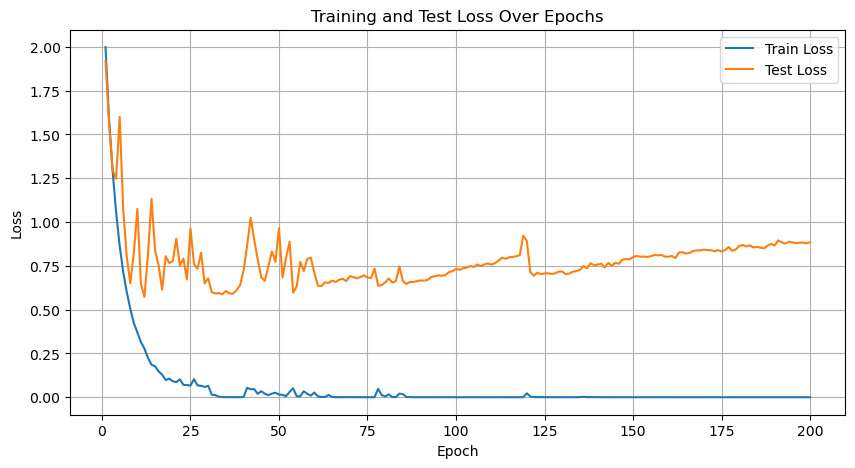

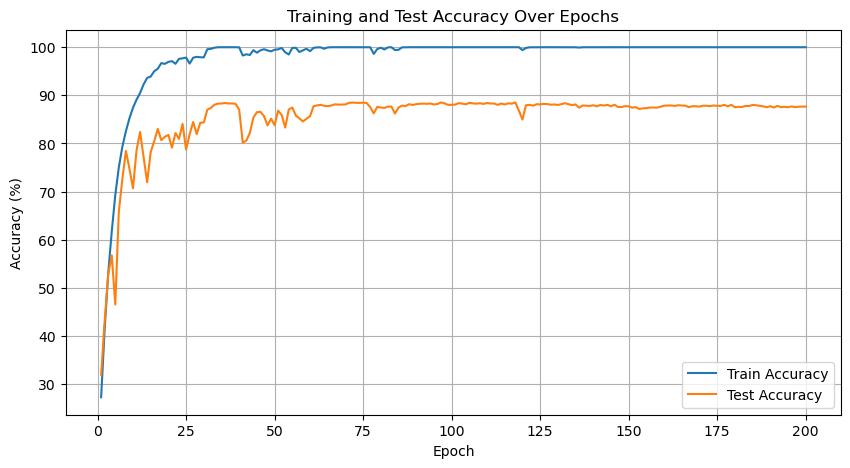

Final Test Accuracy: 87.67%


In [20]:
# Plot loss curves
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Print final test accuracy
print(f"Final Test Accuracy: {test_acc_list[-1]:.2f}%")

In [21]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model
model = FCN_CIFAR10(num_classes=10).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,
#                      weight_decay=5e-4, )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.5)

# Training parameters
num_epochs = 300

# Store loss and accuracy
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Randomly choose between MixUp and CutMix
        use_mixup = random.choice([True, False])
        if use_mixup:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.25)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            images, labels_a, labels_b, lam = cutmix_data(images, labels, alpha=1.0)
            outputs = model(images)
            loss = cutmix_criterion(criterion, outputs, labels_a, labels_b, lam)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()

    train_loss = running_loss / len(trainloader.dataset)
    train_acc = 100 * correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(testloader.dataset)
    test_acc = 100 * correct / total
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], LR: {scheduler.get_last_lr()}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("Training Finished!")




Using device: cuda
Epoch [1/300], LR: [0.01], Train Loss: 2.3950, Train Acc: 14.15%, Test Loss: 2.1007, Test Acc: 24.53%
Epoch [2/300], LR: [0.01], Train Loss: 2.1148, Train Acc: 22.90%, Test Loss: 1.8921, Test Acc: 29.94%
Epoch [3/300], LR: [0.01], Train Loss: 2.0457, Train Acc: 26.25%, Test Loss: 1.7671, Test Acc: 35.56%
Epoch [4/300], LR: [0.01], Train Loss: 1.9602, Train Acc: 29.80%, Test Loss: 1.6547, Test Acc: 37.81%
Epoch [5/300], LR: [0.01], Train Loss: 1.9365, Train Acc: 32.95%, Test Loss: 1.5148, Test Acc: 43.97%
Epoch [6/300], LR: [0.01], Train Loss: 1.8836, Train Acc: 35.26%, Test Loss: 1.5689, Test Acc: 45.97%
Epoch [7/300], LR: [0.01], Train Loss: 1.7258, Train Acc: 41.95%, Test Loss: 1.5423, Test Acc: 46.58%
Epoch [8/300], LR: [0.01], Train Loss: 1.7934, Train Acc: 41.53%, Test Loss: 1.4131, Test Acc: 52.67%
Epoch [9/300], LR: [0.01], Train Loss: 1.6744, Train Acc: 46.08%, Test Loss: 1.2711, Test Acc: 55.75%
Epoch [10/300], LR: [0.01], Train Loss: 1.6202, Train Acc: 49.3

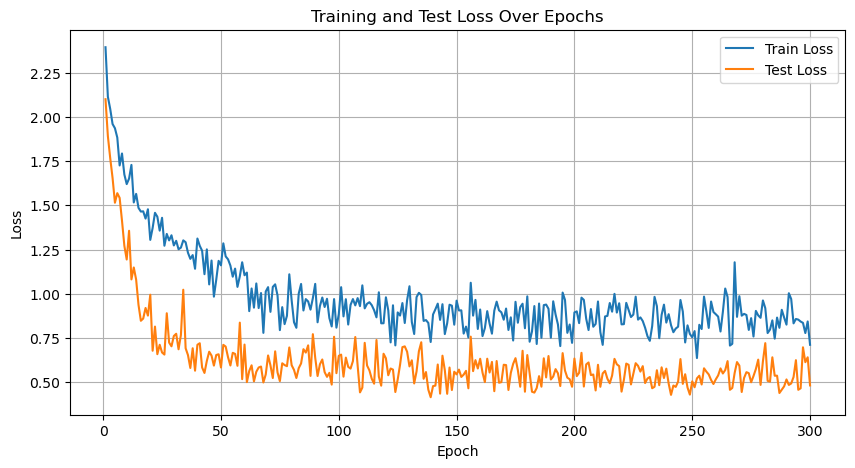

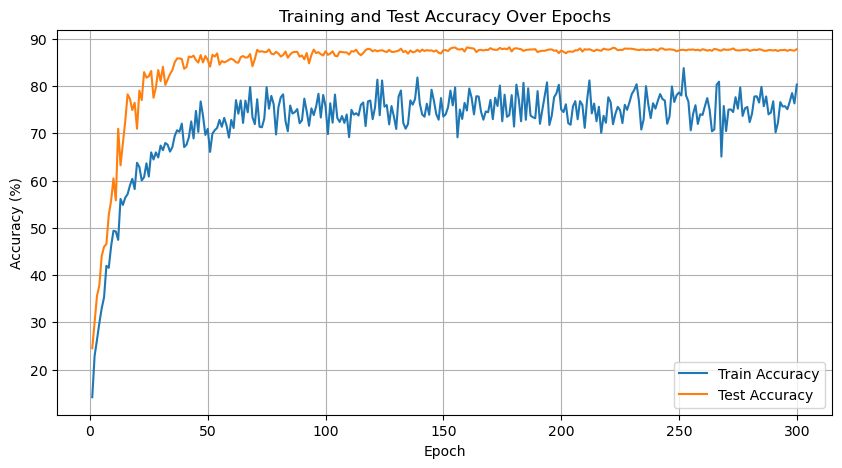

Final Test Accuracy: 87.81%


In [22]:
# Plot loss curves
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Print final test accuracy
print(f"Final Test Accuracy: {test_acc_list[-1]:.2f}%")

In [23]:
from google.colab import runtime
runtime.unassign()

ModuleNotFoundError: No module named 'google'

In [ ]:
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-3)
lr_step_size = 35
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=0.5)
for epoch in range(300):
  #train(...)
  #validate(...)
  optimizer.step()
  scheduler.step()
  #print(f"Epoch: {epoch}, lr: {scheduler.get_last_lr()}")
  if(epoch%lr_step_size == 0):
    print(f"Epoch: {epoch}, lr: {scheduler.get_last_lr()}")

Epoch: 0, lr: [0.01]
Epoch: 35, lr: [0.005]
Epoch: 70, lr: [0.0025]
Epoch: 105, lr: [0.00125]
Epoch: 140, lr: [0.000625]
Epoch: 175, lr: [0.0003125]
Epoch: 210, lr: [0.00015625]
Epoch: 245, lr: [7.8125e-05]
Epoch: 280, lr: [3.90625e-05]
